<a href="https://colab.research.google.com/github/cxbxmxcx/GenReality/blob/master/GEN_2_vanilla_GAN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
#@title IMPORTS
import numpy as np
from matplotlib import pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim
from torch.autograd.variable import Variable
from torchvision import transforms
from torchvision.datasets import MNIST
from torchvision.utils import make_grid
from torch.utils.data import DataLoader
from IPython.display import clear_output

In [3]:
#@title IMAGE HELPERS
def imshow(img,size=10):
  img = img / 2 + 0.5     
  npimg = img.numpy()
  plt.figure(figsize=(size, size))
  plt.imshow(np.transpose(npimg, (1, 2, 0)))
  plt.show()

In [9]:
#@title LOADING DATA
transform = transforms.Compose([
                transforms.ToTensor(),
                transforms.Normalize((0.5,),(0.5,))
                ])
to_image = transforms.ToPILImage()
trainset = MNIST(root='./data/', train=True, download=True, transform=transform)
train_loader = DataLoader(trainset, batch_size=100, shuffle=True)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [5]:
#@title GENERATOR & DISCRIMINATOR
class Generator(nn.Module):
  def __init__(self, latent_dim=128, output_dim=784):
    super(Generator, self).__init__()
    self.latent_dim = latent_dim
    self.output_dim = output_dim
    self.generator = nn.Sequential(
        nn.Linear(self.latent_dim, 256),
        nn.LeakyReLU(0.2),
        nn.Linear(256, 512),
        nn.LeakyReLU(0.2),
        nn.Linear(512, 1024),
        nn.LeakyReLU(0.2),
        nn.Linear(1024, self.output_dim),
        nn.Tanh()
    )

  def forward(self, x):
    x = self.generator(x)
    x = x.view(-1, 1, 28, 28)
    return x

class Discriminator(nn.Module):
  def __init__(self, input_dim=784, output_dim=1):
    super(Discriminator, self).__init__()
    self.input_dim = input_dim
    self.output_dim = output_dim
    self.discriminator = nn.Sequential(
      nn.Linear(self.input_dim, 1024),
      nn.LeakyReLU(0.2),
      nn.Dropout(0.3),
      nn.Linear(1024, 512),
      nn.LeakyReLU(0.2),
      nn.Dropout(0.3),
      nn.Linear(512, 256),
      nn.LeakyReLU(0.2),
      nn.Dropout(0.3),
      nn.Linear(256, self.output_dim),
      nn.Sigmoid()
    )

  def forward(self, x):
        x = x.view(-1, 784)
        x = self.discriminator(x)
        return x


In [6]:
#@title CREATE MODEKS, OPTIMIZERS AND LOSS FUNCTION (CRITERION)
generator = Generator()
discriminator = Discriminator()

generator.to(device)
discriminator.to(device)

g_optim = optim.Adam(generator.parameters(), lr=2e-4)
d_optim = optim.Adam(discriminator.parameters(), lr=2e-4)

g_losses = []
d_losses = []

loss_fn = nn.BCELoss()

def noise(n, n_features=128):
    return Variable(torch.randn(n, n_features)).to(device)

def make_ones(size):
    data = Variable(torch.ones(size, 1))
    return data.to(device)

def make_zeros(size):
    data = Variable(torch.zeros(size, 1))
    return data.to(device)

In [7]:
#@title TRAINING FUNCTIONS
def train_discriminator(optimizer, real_data, fake_data):
    n = real_data.size(0)
    optimizer.zero_grad()
    
    prediction_real = discriminator(real_data)
    loss_real = loss_fn(prediction_real, make_ones(n))
    loss_real.backward()

    prediction_fake = discriminator(fake_data)
    loss_fake = loss_fn(prediction_fake, make_zeros(n))
    
    loss_fake.backward()
    optimizer.step()
    
    return loss_real + loss_fake

def train_generator(optimizer, fake_data):
    n = fake_data.size(0)
    optimizer.zero_grad()
    
    prediction = discriminator(fake_data)
    loss = loss_fn(prediction, make_ones(n))
    
    loss.backward()
    optimizer.step()
    
    return loss

Epoch 16: g_loss: 2.15769434 d_loss: 0.74215227


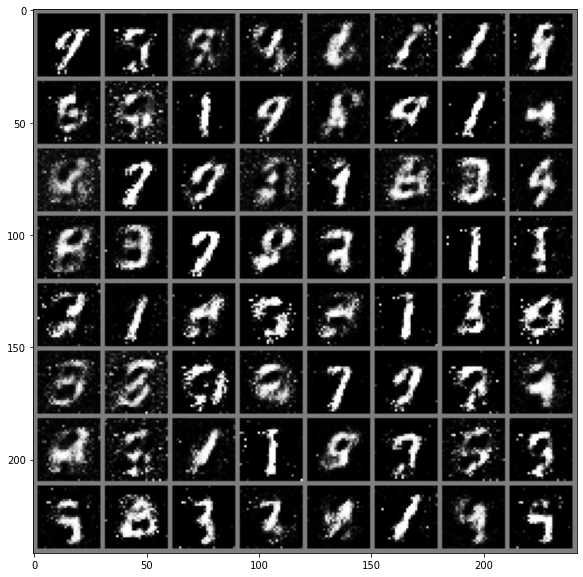

KeyboardInterrupt: ignored

In [8]:
#@title TRAINING
epochs = 250
k = 1
test_noise = noise(64)

generator.train()
discriminator.train()
for epoch in range(epochs):
    g_loss = 0.0
    d_loss = 0.0
    for i, data in enumerate(train_loader):
        imgs, _ = data
        n = len(imgs)
        for j in range(k):
            fake_data = generator(noise(n)).detach()
            real_data = imgs.to(device)
            d_loss += train_discriminator(d_optim, real_data, fake_data)
        fake_data = generator(noise(n))
        g_loss += train_generator(g_optim, fake_data)

    img = generator(test_noise).cpu().detach()        
    g_losses.append(g_loss/i)
    d_losses.append(d_loss/i)
    clear_output()
    print(f'Epoch {epoch+1}: g_loss: {g_loss/i:.8f} d_loss: {d_loss/i:.8f}')
    imshow(make_grid(img))   

In [ ]:
#@title HISTORY
plt.plot(g_losses, label='Generator_Losses')
plt.plot(d_losses, label='Discriminator Losses')
plt.legend()
plt.show()